<a href="https://colab.research.google.com/github/soumendra/cnn-visualisation/blob/master/notebooks/visualising_and_interpreting_cnns_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

![](https://github.com/soumendra/cnn-visualisation/blob/master/notebooks/assets/promiscuous_dlmodel.png?raw=1)

1. Build a small model
2. Visualisation technique 1
3. Visualisation technique 2
4. Visualisation technique 3
5. Real-life Demo

# Colab specific updates

In [1]:
!pip install git+https://github.com/raghakot/keras-vis.git --upgrade

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-g86dy267
  Running setup.py bdist_wheel for keras-vis ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-j8nu6its/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


# Build a small MNIST Model

* Step 1: Build model
* Step 2: Compile
* Step 3: Train
* Step 4: Test

## Data Prep

In [2]:
import numpy as np
import keras

from keras.datasets import mnist
from keras import backend as K

num_classes = 10


# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


11493376/11490434 [==============================] - 4s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## The MNIST Model

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D

batch_size = 128
epochs = 5

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 213us/step - loss: 0.2389 - acc: 0.9277 - val_loss: 0.0521 - val_acc: 0.9823
Epoch 2/5
60000/60000 [==============================] - 9s 143us/step - loss: 0.0835 - acc: 0.9750 - val_loss: 0.0314 - val_acc: 0.9892
Epoch 3/5
60000/60000 [==============================] - 9s 142us/step - loss: 0.0601 - acc: 0.9816 - val_loss: 0.0286 - val_acc: 0.9899
Epoch 4/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.0507 - acc: 0.9841 - val_loss: 0.0335 - val_acc: 0.9886
Epoch 5/5
60000/60000 [==============================] - 9s 143us/step - loss: 0.0426 - acc: 0.9870 - val_loss: 0.0297 - val_acc: 0.9894
Test loss: 0.029696591620478285
Test accuracy: 0.9894


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# Dense Layer Visualizations

* To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations.

* Doing this in keras is tricky, so we provide utils.apply_modifications to modify network parameters and rebuild the graph.

* If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

* Lets start by visualizing input that maximizes the output of node 0. Hopefully this looks like a 0.


# visualize_activation

visualize_activation(model, layer_idx, filter_indices=None, seed_input=None, input_range=(0, 255), \
    backprop_modifier=None, grad_modifier=None, act_max_weight=1, lp_norm_weight=10, \
    tv_weight=10, **optimizer_params)
    
**Args**

* **model**: The keras.models.Model instance. The model input shape must be: (samples, channels, image_dims...) if  image_data_format=channels_first or (samples, image_dims..., channels) if * image_data_format=channels_last.
* **layer_idx**: The layer index within model.layers whose filters needs to be visualized.
* filter_indices: filter indices within the layer to be maximized. If None, all filters are visualized. (Default value = None) For  keras.layers.Dense layer, filter_idx is interpreted as the output index. If you are visualizing final  keras.layers.Dense layer, consider switching 'softmax' activation for 'linear' using utils.apply_modifications for better results. This is generally meant for multi label classifiers.
* **seed_input**: Seeds the optimization with a starting input. Initialized with a random value when set to None. (Default value = None)
* **input_range**: Specifies the input range as a (min, max) tuple. This is used to rescale the final optimized input to the given range. (Default value=(0, 255))
* backprop_modifier: backprop modifier to use. See backprop_modifiers. If you don't specify anything, no backprop modification is applied. (Default value = None)
* grad_modifier: gradient modifier to use. See grad_modifiers. If you don't specify anything, gradients are unchanged (Default value = None)
* act_max_weight: The weight param for ActivationMaximization loss. Not used if 0 or None. (Default value = 1)
* lp_norm_weight: The weight param for LPNorm regularization loss. Not used if 0 or None. (Default value = 10)
* tv_weight: The weight param for TotalVariation regularization loss. Not used if 0 or None. (Default value = 10)
* optimizer_params: The **kwargs for optimizer params. Will default to reasonable values when required keys are not found.
Example:

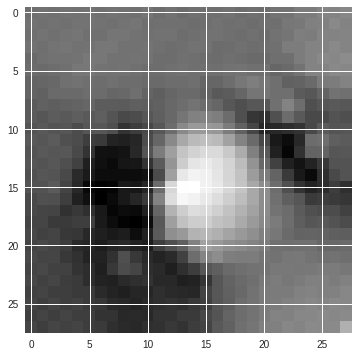

In [5]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

Hmm, it sort of looks like a 0, but not as clear as we hoped for. Activation maximization is notorious because regularization parameters needs to be tuned depending on the problem. Lets enumerate all the possible reasons why this didn't work very well.

The input to network is preprocessed to range (0, 1). We should specify input_range = (0., 1.) to constrain the input to this range.
The regularization parameter default weights might be dominating activation maximization loss weight. One way to debug this is to use verbose=True and examine individual loss values.
Lets do these step by step and see if we can improve it.

# Debugging step 1: Specifying input_range



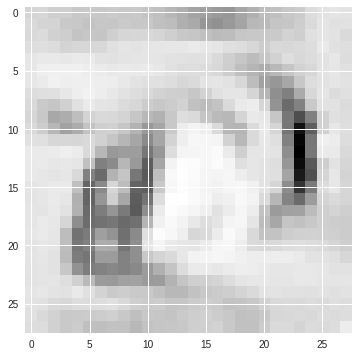

In [6]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
plt.imshow(img[..., 0])

Much better but still seems noisy. Lets examining the losses with verbose=True and tuning the weights.

# Debugging step 2: Tuning regularization weights

One of the issues with activation maximization is that the input can go out of the training distribution space. Total variation and L-p norm are used to provide some hardcoded image priors for natural images. For example, Total variation ensures that images are blobber and not scattered. Unfotunately, sometimes these losses can dominate the main ActivationMaximization loss.

Lets see what individual losses are, with verbose=True

Iteration: 1, named_losses: [('ActivationMax Loss', 0.008516213),
 ('L-6.0 Norm Loss', 0.019833954),
 ('TV(2.0) Loss', 0.09010793)], overall loss: 0.1184580996632576
Iteration: 2, named_losses: [('ActivationMax Loss', -2.75038),
 ('L-6.0 Norm Loss', 0.17218934),
 ('TV(2.0) Loss', 516.7796)], overall loss: 514.201416015625
Iteration: 3, named_losses: [('ActivationMax Loss', -76.773735),
 ('L-6.0 Norm Loss', 0.17921263),
 ('TV(2.0) Loss', 140.75923)], overall loss: 64.16471099853516
Iteration: 4, named_losses: [('ActivationMax Loss', -154.2482),
 ('L-6.0 Norm Loss', 0.18067689),
 ('TV(2.0) Loss', 152.62283)], overall loss: -1.4446868896484375
Iteration: 5, named_losses: [('ActivationMax Loss', -238.98727),
 ('L-6.0 Norm Loss', 0.20589057),
 ('TV(2.0) Loss', 142.26881)], overall loss: -96.5125732421875
Iteration: 6, named_losses: [('ActivationMax Loss', -324.57806),
 ('L-6.0 Norm Loss', 0.24147624),
 ('TV(2.0) Loss', 155.27832)], overall loss: -169.05825805664062
Iteration: 7, named_losse

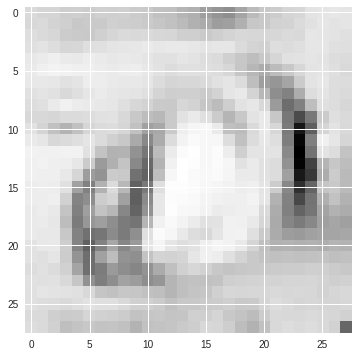

In [7]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
plt.imshow(img[..., 0])


In this case, ActivationMax Loss is not bouncing bouncing around and converging? Perhaps we could get that loss to be lower by reducing weights of other losses that might be dominating the overall loss being minimized.

The simplest way to tune these weights is to first start with 0. weights for all regularization losses.



Iteration: 1, named_losses: [('ActivationMax Loss', 0.15520865)], overall loss: 0.15520864725112915
Iteration: 2, named_losses: [('ActivationMax Loss', -32.58528)], overall loss: -32.58528137207031
Iteration: 3, named_losses: [('ActivationMax Loss', -181.64789)], overall loss: -181.64788818359375
Iteration: 4, named_losses: [('ActivationMax Loss', -384.38998)], overall loss: -384.3899841308594
Iteration: 5, named_losses: [('ActivationMax Loss', -577.9596)], overall loss: -577.9595947265625
Iteration: 6, named_losses: [('ActivationMax Loss', -772.90405)], overall loss: -772.904052734375
Iteration: 7, named_losses: [('ActivationMax Loss', -955.7851)], overall loss: -955.7850952148438
Iteration: 8, named_losses: [('ActivationMax Loss', -1122.6765)], overall loss: -1122.676513671875
Iteration: 9, named_losses: [('ActivationMax Loss', -1283.6672)], overall loss: -1283.667236328125
Iteration: 10, named_losses: [('ActivationMax Loss', -1430.4316)], overall loss: -1430.431640625
Iteration: 11,

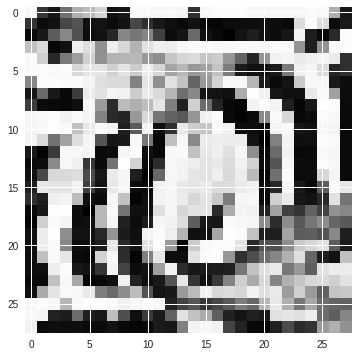

In [8]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                           tv_weight=0., lp_norm_weight=0., verbose=True)
plt.imshow(img[..., 0])

It does indeed go to much lower values, but the image looks less natural. Let's try varous range of total variation weights to enforce naturalness.

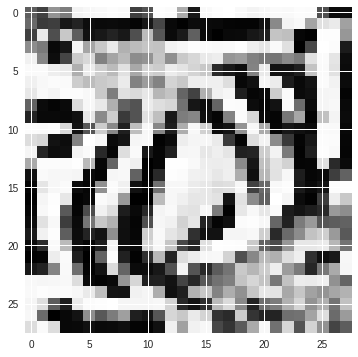

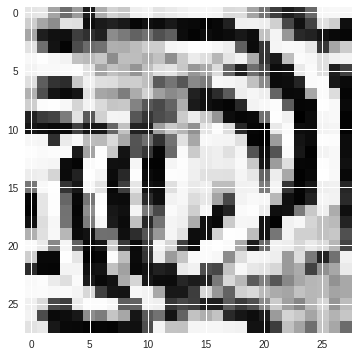

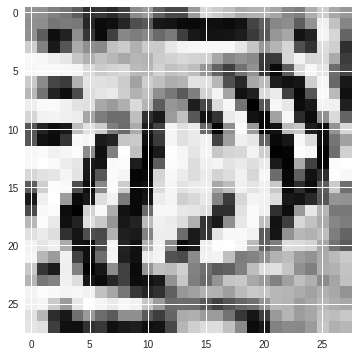

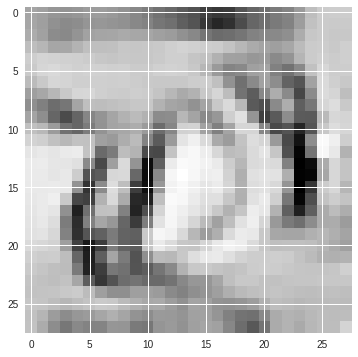

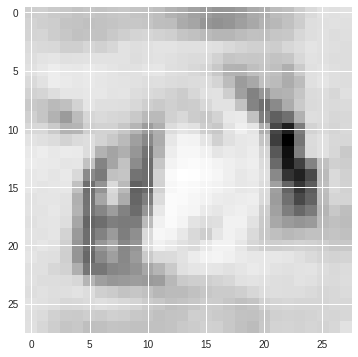

In [9]:
for tv_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=tv_weight, lp_norm_weight=0.)
    plt.figure()
    plt.imshow(img[..., 0])

* Obviously you can tune the visualizations to look better by experimenting with image_modifiers, lp-norm weight etc. Basically, a regularizer is needed to enforce image naturalness prior to limit the input image search space.

* For using custom loss, you can use visualize_activation_with_losses API.

# Visualizations without swapping softmax


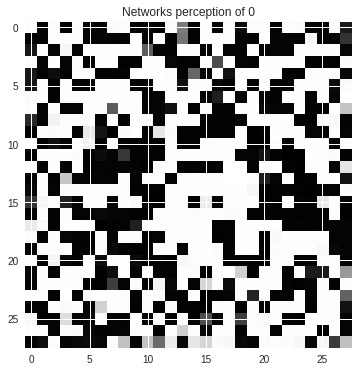

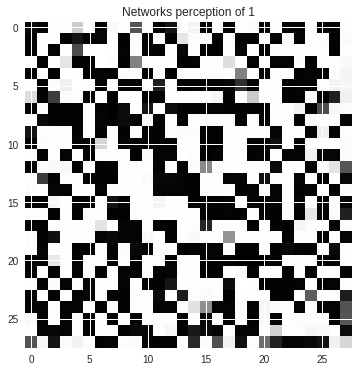

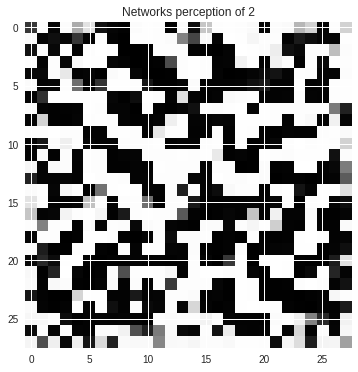

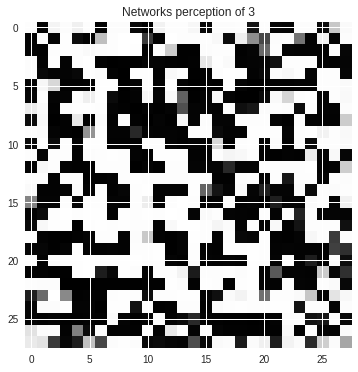

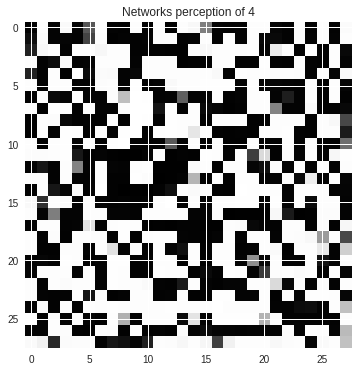

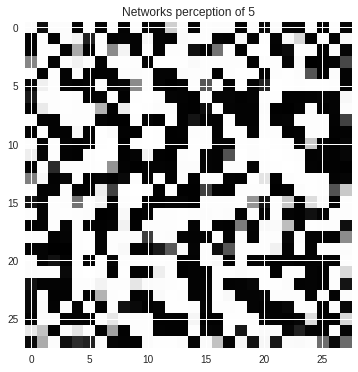

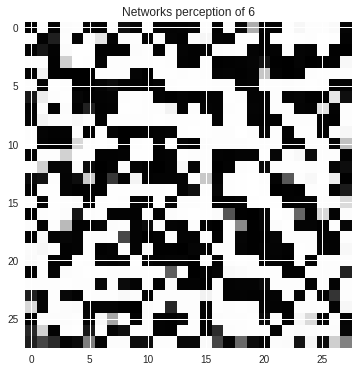

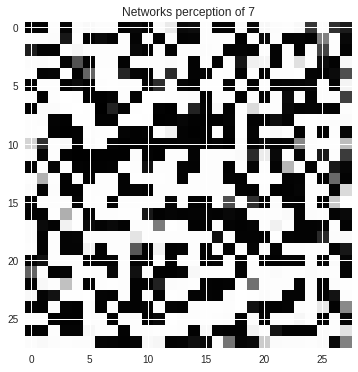

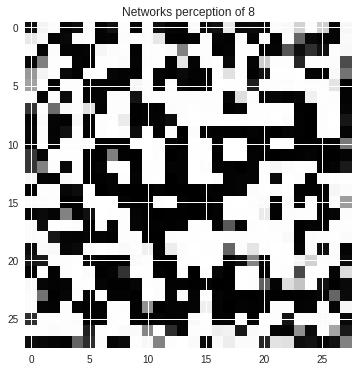

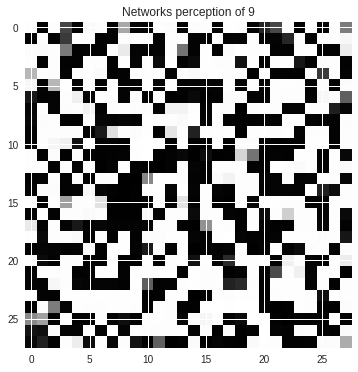

In [10]:
# Swap linear back with softmax
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

It does not work! The reason is that maximizing an output node can be done by minimizing other outputs. Softmax is weird that way. It is the only activation that depends on other node output(s) in the layer.

# Saliency

To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide utils.apply_modifications to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

Lets pick an input over which we want to show the attention.

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 168us/step - loss: 0.2401 - acc: 0.9278 - val_loss: 0.0574 - val_acc: 0.9825
Epoch 2/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.0877 - acc: 0.9737 - val_loss: 0.0371 - val_acc: 0.9881
Epoch 3/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.0635 - acc: 0.9809 - val_loss: 0.0316 - val_acc: 0.9895
Epoch 4/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.0516 - acc: 0.9840 - val_loss: 0.0274 - val_acc: 0.9915
Epoch 5/5
60000/60000 [==============================] - 9s 145us/step - loss: 0.0440 - acc: 0.9862 - val_loss: 0.0307 - val_acc: 0.9892
Test loss: 0.030722268549215368
Test accuracy: 0.9892


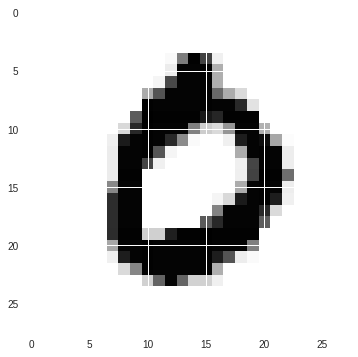

In [12]:
import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

class_idx = 0
indices = np.where(y_test[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(x_test[idx][..., 0])

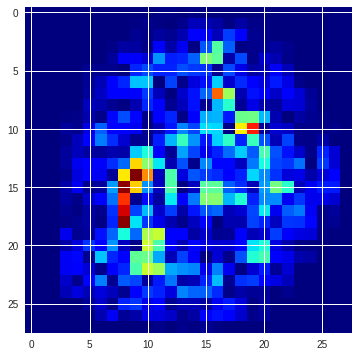

In [13]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

To used guided saliency, we need to set backprop_modifier='guided'. For rectified saliency or deconv saliency, use backprop_modifier='relu'. Lets try these options quickly and see how they compare to vanilla saliency.

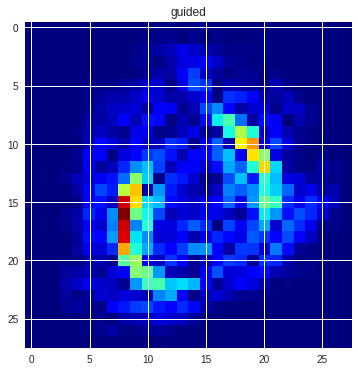

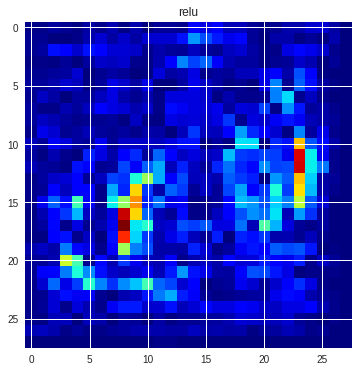

In [14]:
for modifier in ['guided', 'relu']:
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx], backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

Both of them look a lot better than vanilla saliency! This in inline with observation in the paper.

We can also visualize negative gradients to see the parts of the image that contribute negatively to the output by using grad_modifier='negate'.


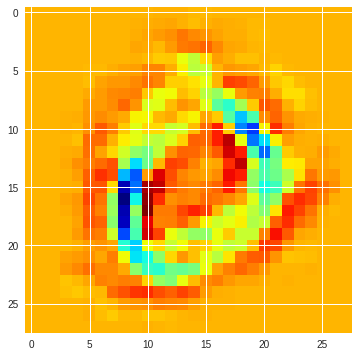

In [15]:
grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx], 
                           backprop_modifier='guided', grad_modifier='negate')
plt.imshow(grads, cmap='jet')

In [16]:
Lets try all the classes and show original inputs and their heatmaps side by side. We cannot overlay the heatmap on original image since its grayscale.

We will also compare the outputs of guided and rectified or deconv saliency.

SyntaxError: ignored

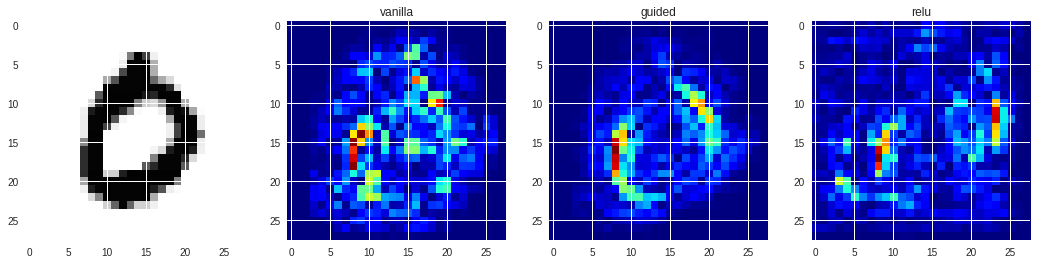

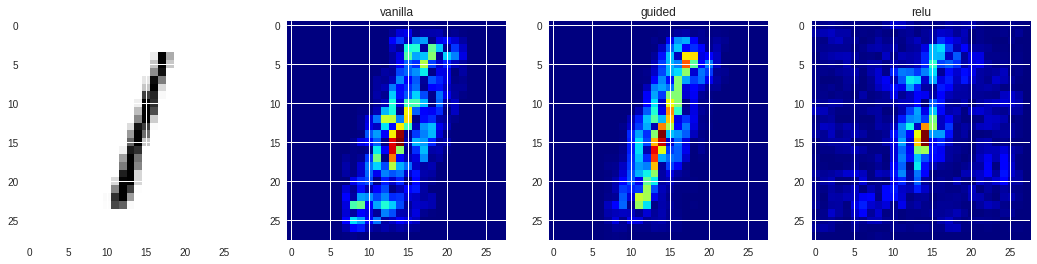

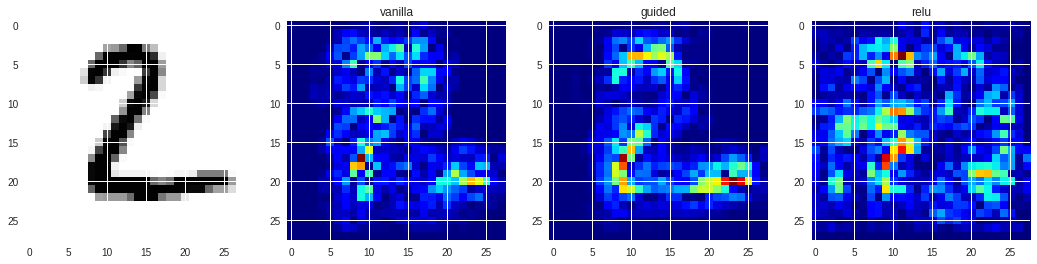

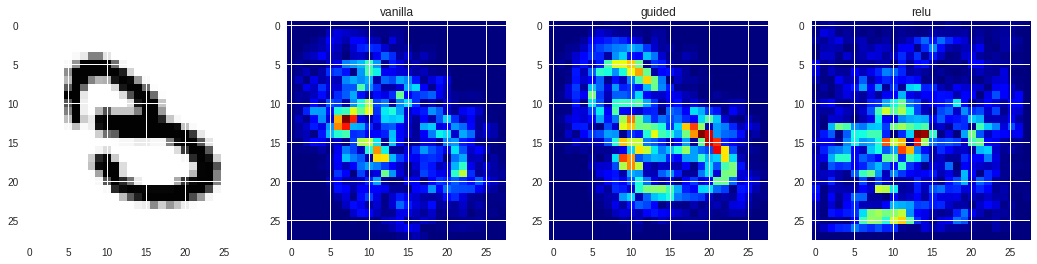

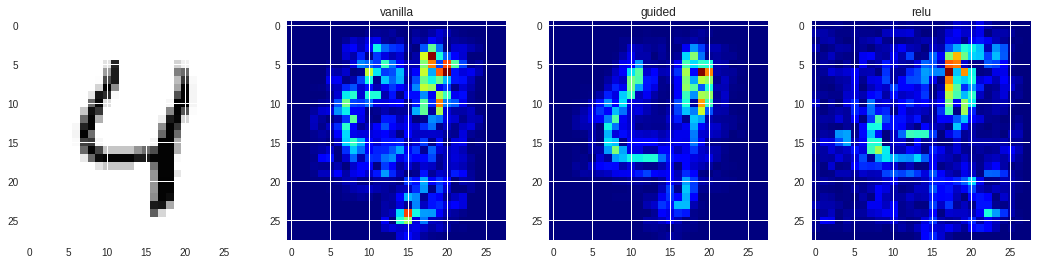

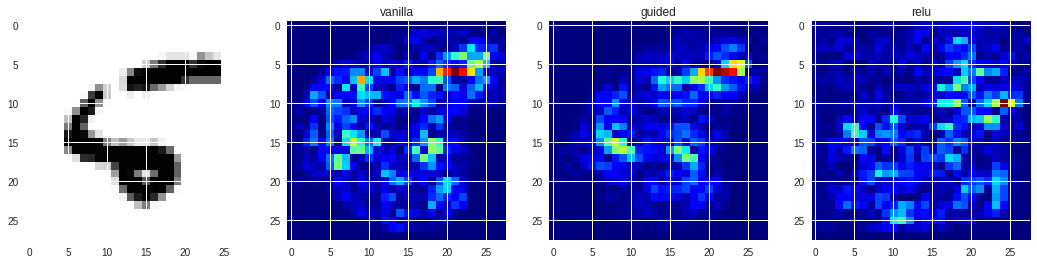

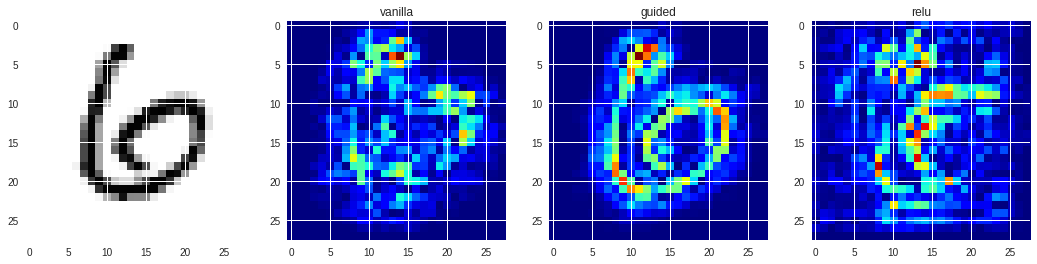

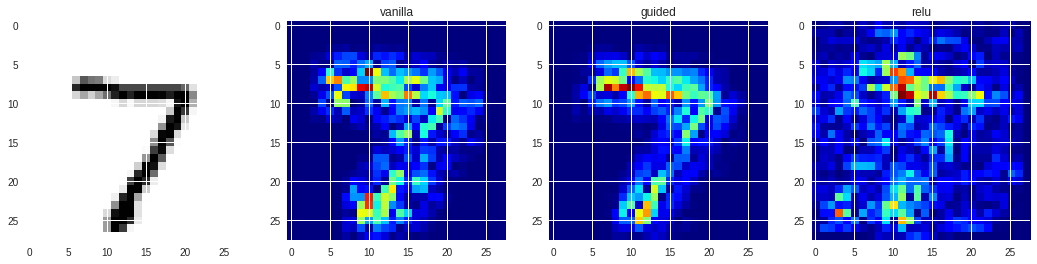

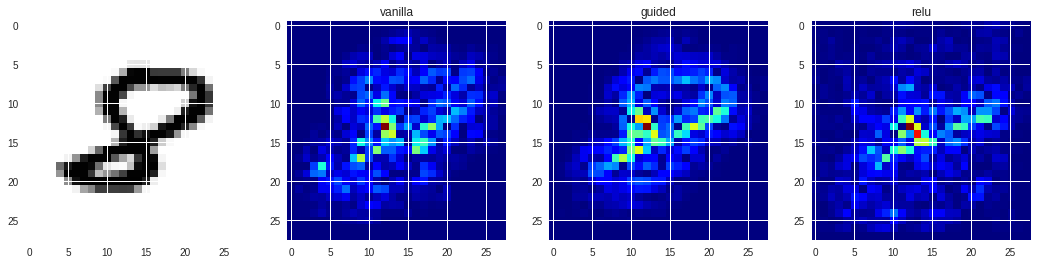

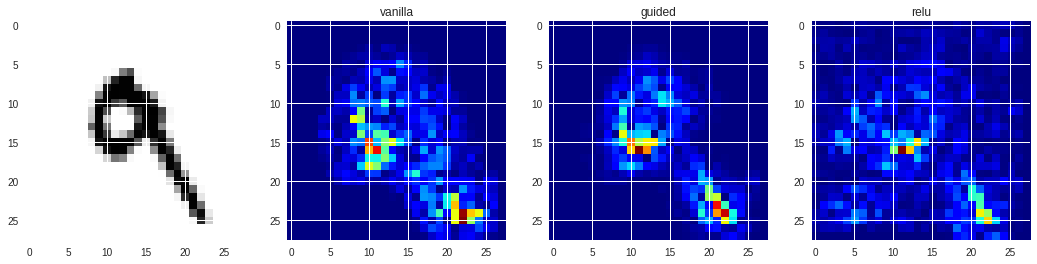

In [17]:
# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=x_test[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')


# grad-CAM - vanilla, guided, rectified
These should contain more detail since they use Conv or Pooling features that contain more spatial detail which is lost in Dense layers. The only additional detail compared to saliency is the penultimate_layer_idx. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if penultimate_layer_idx is not defined, it searches for the nearest pre layer. For our architecture, that would be the MaxPooling2D layer after all the Conv layers. Lets look at all the visualizations like before.

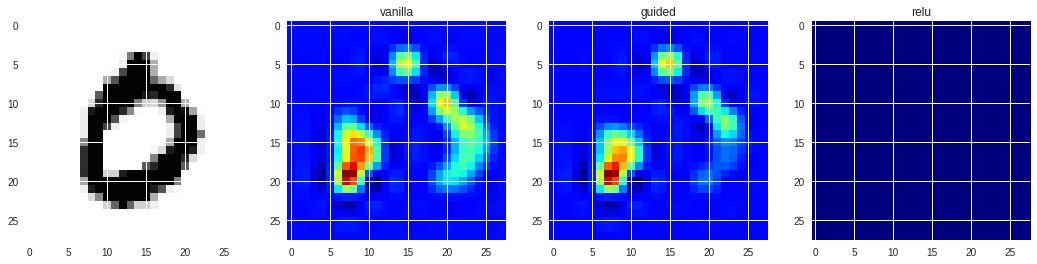

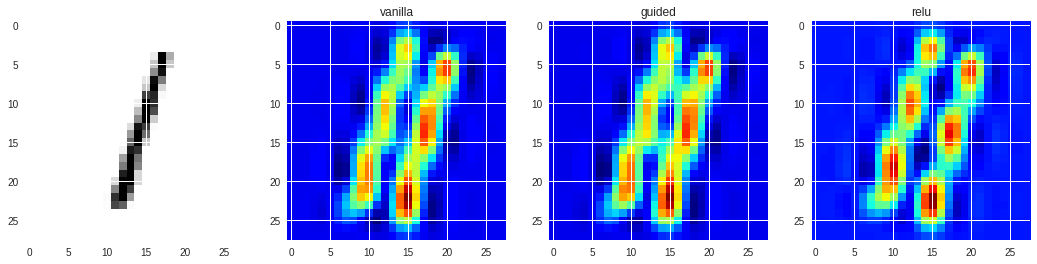

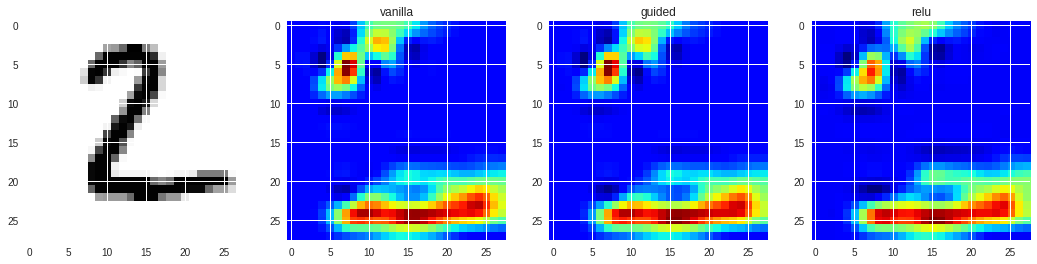

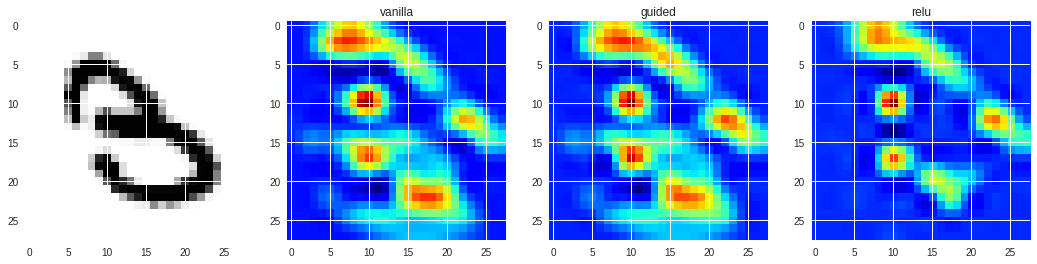

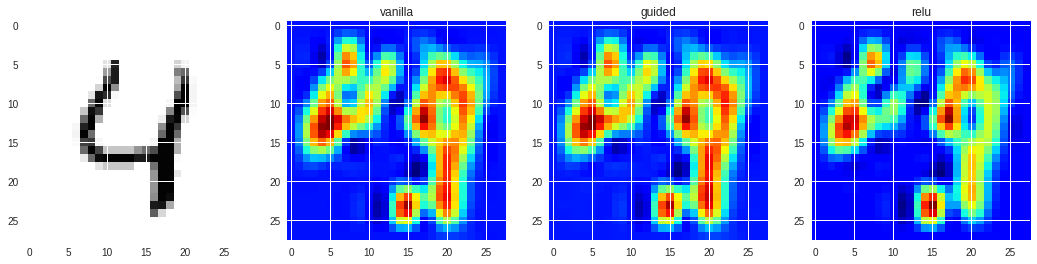

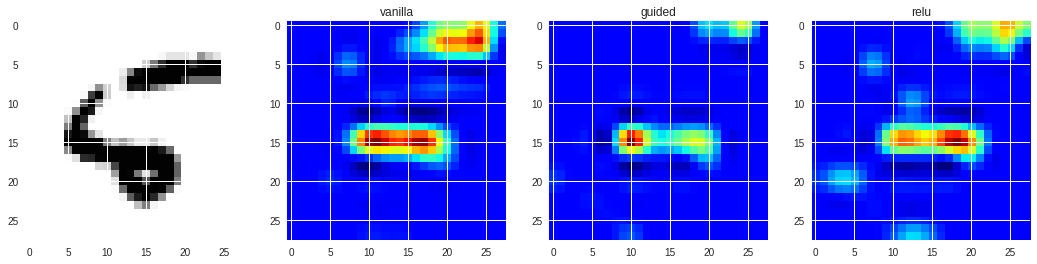

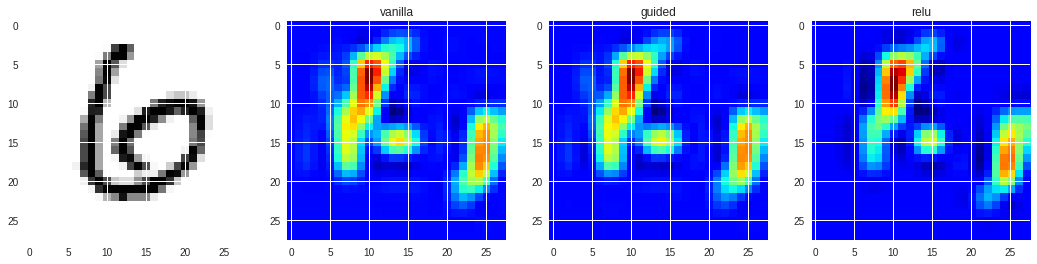

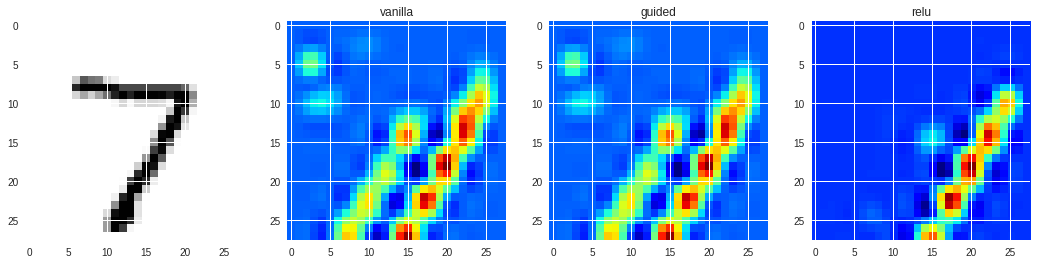

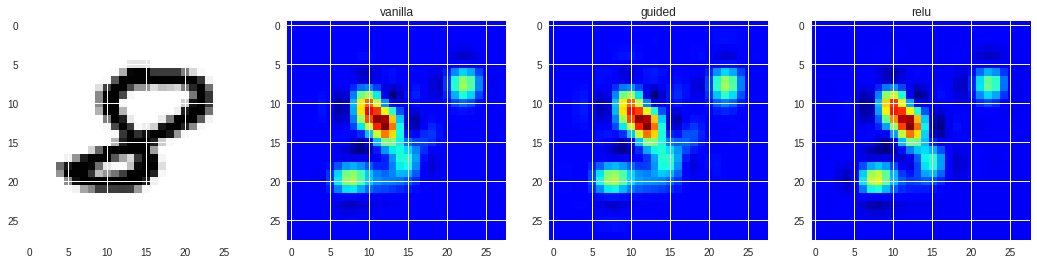

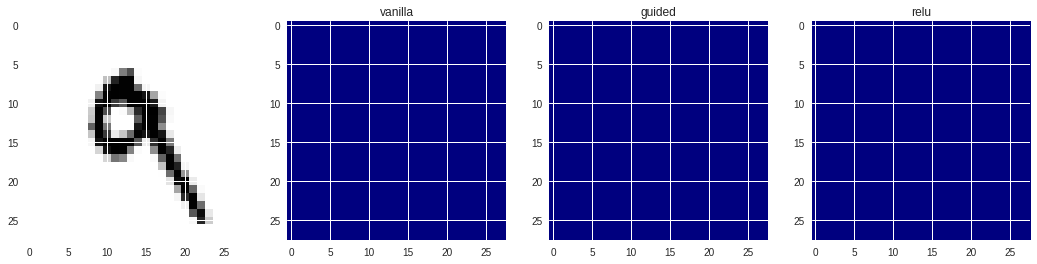

In [18]:
from vis.visualization import visualize_cam

# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=x_test[idx], backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

In this case it appears that saliency is better than grad-CAM as penultimate MaxPooling2D layer has (12, 12) spatial resolution which is relatively large as compared to input of (28, 28). Is is likely that the conv layer hasnt captured enough high level information and most of that is likely within dense_4 layer.

Here is the model summary for reference.